# PSET #2 By Zachary Mariani

## 1. Introduction

### Student ID # 12188511, so 1

In [1]:
#standard imports 
import pandas as pd 
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import quandl
import functools
import os
import math

my_api_key = HIDDEN 
pd.set_option("max_columns", None) 
pd.set_option("max_rows", None)

#### Parameters to later tune ##### 
j_global = 0.025
g_global = 0.05
s_global = 1
M_global = 15

## 2. Data

In [2]:
#my pairs are $RYE and $XOP

X_raw = quandl.get('EOD/RYE', returns = 'pandas', 
            api_key = my_api_key, start_date = '2018-12-02', end_date = '2020-12-31')
Y_raw = quandl.get('EOD/XOP', returns = 'pandas', 
            api_key = my_api_key, start_date = '2018-12-02', end_date = '2020-12-31')

In [3]:
of_interest = ['Adj_Close', 'Adj_Volume']

X_raw = X_raw[of_interest]
Y_raw = Y_raw[of_interest]

In [4]:
X_raw.loc[(X_raw['Adj_Volume'] == 52863.0)]['Adj_Close'].mean()

48.32557777469062

In [5]:
#NB: this assumes that the spilt- and dividend-adjusted close prices are accurately reported in the 
#"adj_close" column of the Quandl df, I think this is correct, but I should double check before I turn this in

def estimate_daily_dollar_volume(sec): 
    sec['Estimated_Daily_Dollar_Volume'] = sec['Adj_Close'] * sec['Adj_Volume']
    return 

estimate_daily_dollar_volume(X_raw)
estimate_daily_dollar_volume(Y_raw)

def get_rolling_median(n, sec): 
    sec['Rolling_Volume_%s_Day_Median' %n] = sec['Estimated_Daily_Dollar_Volume'].rolling(n).median()
    return 

get_rolling_median(15, X_raw)
get_rolling_median(15, Y_raw)

#it seems like something went wrong here given that N_t and N_t_sec always choose RYE!

def get_N_t(sec1, sec2): 

    X = pd.DataFrame(sec1['Rolling_Volume_15_Day_Median'])
    X['sec'] = 'RYE'
    Y = pd.DataFrame(sec2['Rolling_Volume_15_Day_Median'])
    Y['sec'] = 'XOP'
    Z = X.append(Y)
    Z.sort_values(by = ['Date', 'Rolling_Volume_15_Day_Median'], inplace=True)
    Z = Z[~Z.index.duplicated(keep = 'first')]
    
    sec1['N_t'] = Z['Rolling_Volume_15_Day_Median']
    sec2['N_t'] = Z['Rolling_Volume_15_Day_Median']
    
    sec1['N_t_sec'] = Z['sec']
    sec2['N_t_sec'] = Z['sec']
    
    
X = X_raw
Y = Y_raw

#get the M-day return on X and Y 
X['returns'] = X['Adj_Close'].pct_change(M_global)
Y['returns'] = Y['Adj_Close'].pct_change(M_global)

get_N_t(X_raw, Y_raw)
X_raw.head()


,Adj_Close,Adj_Volume,Estimated_Daily_Dollar_Volume,Rolling_Volume_15_Day_Median,returns,N_t,N_t_sec
Date,,,,,,,
2018-12-03,48.325578,52863.0,2.554635e+06,NaN,NaN,NaN,RYE
2018-12-04,46.848214,48633.0,2.278369e+06,NaN,NaN,NaN,RYE
2018-12-06,45.714640,91944.0,4.203187e+06,NaN,NaN,NaN,RYE
2018-12-07,45.482350,66265.0,3.013888e+06,NaN,NaN,NaN,RYE
2018-12-10,44.450983,45322.0,2.014607e+06,NaN,NaN,NaN,RYE


<AxesSubplot:xlabel='Date'>

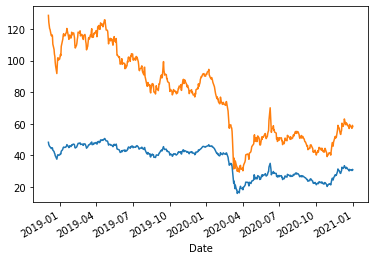

In [6]:
X['Adj_Close'].plot()
Y['Adj_Close'].plot()

In [7]:
#I cleaned a bit of the data in the CSV, getting rid of the extra text etc 
F_and_F = pd.read_csv('/Users/zachmariani/FINM/F&F.CSV')

#cut out a lot to make it faster
F_and_F = F_and_F.iloc[22000:]

#fix the indexing of the data
F_and_F['Date'] = F_and_F['Date'].apply(str)
F_and_F['Date'] = F_and_F['Date'].str[0:4] + '-' + F_and_F['Date'].str[4:6] + '-' + F_and_F['Date'].str[6:8]
F_and_F['Date'] = pd.to_datetime(F_and_F['Date'])

F_and_F = F_and_F.set_index('Date')
F_and_F.head(10)

,Mkt-RF,SMB,HML,RF
Date,,,,
2009-07-02,-2.89,-0.58,-1.06,0.001
2009-07-06,-0.03,-0.92,-0.95,0.001
2009-07-07,-1.93,0.03,-0.14,0.001
2009-07-08,-0.20,-0.54,-1.11,0.001
2009-07-09,0.35,-0.60,1.25,0.001
2009-07-10,-0.35,0.94,-0.53,0.001
2009-07-13,2.43,-0.70,1.80,0.001
2009-07-14,0.59,0.30,0.59,0.001
2009-07-15,2.98,0.52,1.35,0.001


In [8]:
#filter down the days to the same start and end days as we have for the Quandl data 
F_and_F = F_and_F.loc['2018-12-02':'2020-12-31']
F_and_F.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2018-12-03,1.13,-0.07,-0.79,0.01
2018-12-04,-3.45,-0.96,-0.18,0.01
2018-12-06,-0.16,0.12,-1.04,0.01
2018-12-07,-2.36,0.19,1.33,0.01
2018-12-10,0.10,-0.15,-1.65,0.01


## 3 Exercise 
### 3.1 Positions


In [9]:
F_and_F_first_days_of_month = F_and_F.iloc[F_and_F.reset_index().groupby(F_and_F.index.to_period('M'))['Date'].idxmin()]
F_and_F_first_days_of_month['First_Day_of_the_Month'] = 1

#disqualify this first one as per assignment
F_and_F_first_days_of_month.at['2018-12-03', 'First_Day_of_the_Month'] = None

#this is to get the first days of the month, it assumes that the first days of the F and F data
# are the first days of the Quandl Data, not sure if this is a true assumption, but figured it should hold
# because it must be based on when markets are open ...
F_and_F_first_days_of_month.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Mkt-RF,SMB,HML,RF,First_Day_of_the_Month
Date,,,,,
2018-12-03,1.13,-0.07,-0.79,0.010,NaN
2019-01-02,0.23,0.56,1.10,0.010,1.0
2019-02-01,0.14,-0.15,0.40,0.010,1.0
2019-03-01,0.72,0.29,-0.41,0.009,1.0
2019-04-01,1.19,-0.32,0.97,0.010,1.0


In [10]:
#here we do a similar thing to get the last days of the month 
F_and_F_last_days_of_month = F_and_F.iloc[F_and_F.reset_index().groupby(F_and_F.index.to_period('M'))['Date'].idxmax()]
F_and_F_last_days_of_month['Last_Day_of_the_Month'] = 1

#we get rid of this one 
F_and_F_last_days_of_month.at['2018-12-31', 'Last_Day_of_the_Month'] = None

F_and_F_last_days_of_month.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Mkt-RF,SMB,HML,RF,Last_Day_of_the_Month
Date,,,,,
2018-12-31,0.90,-0.09,-0.46,0.010,NaN
2019-01-31,0.92,0.14,-1.07,0.010,1.0
2019-02-28,-0.31,0.02,-0.24,0.010,1.0
2019-03-29,0.66,-0.21,-0.92,0.009,1.0
2019-04-30,-0.04,-0.69,0.27,0.010,1.0


In [11]:
X['N_t_over_100'] = X['N_t'] / 100
Y['N_t_over_100'] = Y['N_t'] / 100

#this gets the number of shares we could possibly trade on each day 
X['num_of_shares_to_possibly_trade'] = np.floor(X['N_t_over_100'] / X['Adj_Close'])
Y['num_of_shares_to_possibly_trade'] = np.floor(Y['N_t_over_100'] / Y['Adj_Close'])


#we then transition from just the data to what I call the algorithm book 
algorithm_book = pd.DataFrame()
algorithm_book['Spread'] = np.abs(X['returns'] - Y['returns'])
algorithm_book['X_recent_return'] = X['returns']
algorithm_book['Y_recent_return'] = Y['returns']

#copy over a couple of things that will be useful to have 
algorithm_book['X_shares_to_possibly_trade'] = X['num_of_shares_to_possibly_trade']
algorithm_book['Y_shares_to_possibly_trade'] = Y['num_of_shares_to_possibly_trade']

algorithm_book['X_adj_close'] = X['Adj_Close']
algorithm_book['Y_adj_close'] = Y['Adj_Close']

#as mentioned earlierthis logic assumes that the F and F data has the exact same timeseries as the Quandl data
#might be worth a minute to just double check 
algorithm_book['First_Day_of_the_Month'] = F_and_F_first_days_of_month['First_Day_of_the_Month']
algorithm_book['Last_Day_of_the_Month'] = F_and_F_last_days_of_month['Last_Day_of_the_Month']
algorithm_book['Must_Close'] = algorithm_book['Last_Day_of_the_Month']
algorithm_book['Eligible_to_Open'] = \
algorithm_book['First_Day_of_the_Month'].fillna(method = 'ffill') - algorithm_book['Must_Close'].fillna(0)



algorithm_book.loc[(algorithm_book['Spread'] > g_global) & \
                   (algorithm_book['Eligible_to_Open'] == 1), 'spread_above_g_and_eligible_to_open'] = 1

algorithm_book['spread_above_g_shift'] = algorithm_book['spread_above_g_and_eligible_to_open'].shift(1).fillna(0)
algorithm_book.loc[(algorithm_book['spread_above_g_and_eligible_to_open'] - \
                    algorithm_book['spread_above_g_shift'] == 1), 'opened_today'] = 1.0

algorithm_book.loc[(algorithm_book['Spread']) < j_global, 'spread_below_j'] = 0

#to clean it up
algorithm_book.drop('spread_above_g_shift', axis = 1, inplace=True)

algorithm_book.loc[(algorithm_book['X_recent_return'] > algorithm_book['Y_recent_return']), 'sec_to_short'] = 'X'
algorithm_book.loc[(algorithm_book['X_recent_return'] < algorithm_book['Y_recent_return']), 'sec_to_short'] = 'Y'

algorithm_book['currently_open'] = algorithm_book['opened_today'].add(algorithm_book['spread_below_j'], fill_value =0).fillna(method = 'ffill')



X_map = {
    'X' : -1, 
    'Y' : 1
}
x_multiplier = algorithm_book['sec_to_short'].replace(X_map)

Y_map = {
    'Y' : -1, 
    'X' : 1
}
y_multiplier = algorithm_book['sec_to_short'].replace(Y_map)




algorithm_book.loc[(algorithm_book['opened_today'] == 1) , 'x_shares_traded_today'] = \
    algorithm_book['X_shares_to_possibly_trade'] * x_multiplier

algorithm_book.loc[(algorithm_book['opened_today'] == 1) , 'y_shares_traded_today'] = \
    algorithm_book['Y_shares_to_possibly_trade'] * y_multiplier

running_x = algorithm_book['x_shares_traded_today'].copy().fillna(method = 'ffill')
running_y = algorithm_book['y_shares_traded_today'].copy().fillna(method = 'ffill')



#if they closed 
closed_today = algorithm_book['currently_open'] - algorithm_book['currently_open'].fillna(0).shift(1)

algorithm_book.loc[(closed_today == -1) , 'x_shares_traded_today'] = \
     -1 * running_x

algorithm_book.loc[(closed_today == -1) , 'y_shares_traded_today'] = \
     -1 * running_y

algorithm_book['x_on_books'] = algorithm_book['x_shares_traded_today'].fillna(method = 'ffill')
algorithm_book.loc[(algorithm_book['currently_open'] == 0), 'x_on_books'] = 0
algorithm_book['y_on_books'] = algorithm_book['y_shares_traded_today'].fillna(method = 'ffill')
algorithm_book.loc[(algorithm_book['currently_open'] == 0), 'y_on_books'] = 0





algorithm_book.iloc[39:100]






,Spread,X_recent_return,Y_recent_return,X_shares_to_possibly_trade,Y_shares_to_possibly_trade,X_adj_close,Y_adj_close,First_Day_of_the_Month,Last_Day_of_the_Month,Must_Close,Eligible_to_Open,spread_above_g_and_eligible_to_open,opened_today,spread_below_j,sec_to_short,currently_open,x_shares_traded_today,y_shares_traded_today,x_on_books,y_on_books
Date,,,,,,,,,,,,,,,,,,,,
2019-01-31,0.034173,0.033846,-0.000327,628.0,251.0,46.521199,116.252463,NaN,1.0,1.0,0.0,NaN,NaN,NaN,X,0.0,NaN,NaN,0.0,0.0
2019-02-01,0.036538,0.035236,-0.001301,622.0,250.0,46.913626,116.861513,1.0,NaN,NaN,1.0,NaN,NaN,NaN,X,0.0,NaN,NaN,0.0,0.0
2019-02-04,0.030864,0.046654,0.015789,619.0,248.0,47.195332,117.546694,NaN,NaN,NaN,1.0,NaN,NaN,NaN,X,0.0,NaN,NaN,0.0,0.0
2019-02-05,0.041128,0.042443,0.001315,621.0,252.0,47.044434,115.947937,NaN,NaN,NaN,1.0,NaN,NaN,NaN,X,0.0,NaN,NaN,0.0,0.0
2019-02-06,0.050891,0.029116,-0.021774,626.0,255.0,46.680039,114.577574,NaN,NaN,NaN,1.0,1.0,1.0,NaN,X,1.0,-626.0,255.0,-626.0,255.0
2019-02-07,0.058642,-0.007203,-0.065845,651.0,267.0,45.072960,109.629041,NaN,NaN,NaN,1.0,1.0,NaN,NaN,X,1.0,NaN,NaN,-626.0,255.0
2019-02-08,0.059416,-0.026041,-0.085456,656.0,271.0,44.727251,107.954153,NaN,NaN,NaN,1.0,1.0,NaN,NaN,X,1.0,NaN,NaN,-626.0,255.0
2019-02-11,0.053952,-0.034311,-0.088263,649.0,267.0,45.231799,109.705173,NaN,NaN,NaN,1.0,1.0,NaN,NaN,X,1.0,NaN,NaN,-626.0,255.0
2019-02-12,0.038617,0.001641,-0.036976,615.0,253.0,45.624225,111.037470,NaN,NaN,NaN,1.0,NaN,NaN,NaN,X,1.0,NaN,NaN,-626.0,255.0


In [12]:
algorithm_book.loc[(algorithm_book['x_on_books'] != 0), 'PnL_needed_on_this_day'] = 1
algorithm_book['PnL_needed_on_this_day'] = algorithm_book['PnL_needed_on_this_day'].shift(1)

num_of_contracts_held = algorithm_book['x_on_books'].shift(1)
price_change_per_contract = algorithm_book['X_adj_close'].diff()
algorithm_book['x_pnl'] = price_change_per_contract * num_of_contracts_held

num_of_contracts_held = algorithm_book['y_on_books'].shift(1)
price_change_per_contract = algorithm_book['Y_adj_close'].diff()
algorithm_book['y_pnl'] = price_change_per_contract * num_of_contracts_held

algorithm_book['PnL_total'] = algorithm_book['x_pnl'] + algorithm_book['y_pnl']

algorithm_book['PnL_cumsum'] = algorithm_book['PnL_total'].cumsum()

algorithm_book[50:100]

,Spread,X_recent_return,Y_recent_return,X_shares_to_possibly_trade,Y_shares_to_possibly_trade,X_adj_close,Y_adj_close,First_Day_of_the_Month,Last_Day_of_the_Month,Must_Close,Eligible_to_Open,spread_above_g_and_eligible_to_open,opened_today,spread_below_j,sec_to_short,currently_open,x_shares_traded_today,y_shares_traded_today,x_on_books,y_on_books,PnL_needed_on_this_day,x_pnl,y_pnl,PnL_total,PnL_cumsum
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-15,0.016766,0.032160,0.015395,573.0,231.0,47.631579,118.003482,NaN,NaN,NaN,1.0,NaN,NaN,0.0,X,0.0,626.0,-255.0,0.0,0.0,1.0,-490.381841,786.24578,295.863939,494.311647
2019-02-19,0.018726,0.047726,0.029000,572.0,232.0,47.791913,117.508629,NaN,NaN,NaN,1.0,NaN,NaN,0.0,X,0.0,NaN,NaN,0.0,0.0,NaN,0.000000,-0.00000,0.000000,494.311647
2019-02-20,0.010468,0.046301,0.035833,611.0,247.0,47.988126,118.840926,NaN,NaN,NaN,1.0,NaN,NaN,0.0,X,0.0,NaN,NaN,0.0,0.0,NaN,0.000000,0.00000,0.000000,494.311647
2019-02-21,0.026014,0.006007,-0.020006,640.0,260.0,46.941656,115.605347,NaN,NaN,NaN,1.0,NaN,NaN,NaN,X,0.0,NaN,NaN,0.0,0.0,NaN,-0.000000,-0.00000,-0.000000,494.311647
2019-02-22,0.008433,0.011380,0.002947,624.0,251.0,47.050601,116.595053,NaN,NaN,NaN,1.0,NaN,NaN,0.0,X,0.0,NaN,NaN,0.0,0.0,NaN,0.000000,0.00000,0.000000,494.311647
2019-02-25,0.009485,0.005577,-0.003909,579.0,234.0,47.175243,116.404725,NaN,NaN,NaN,1.0,NaN,NaN,0.0,X,0.0,NaN,NaN,0.0,0.0,NaN,0.000000,-0.00000,0.000000,494.311647
2019-02-26,0.018049,-0.006563,-0.024611,583.0,238.0,46.885595,114.653706,NaN,NaN,NaN,1.0,NaN,NaN,0.0,X,0.0,NaN,NaN,0.0,0.0,NaN,-0.000000,-0.00000,-0.000000,494.311647
2019-02-27,0.008130,-0.001390,-0.009521,581.0,238.0,46.979030,114.844034,NaN,NaN,NaN,1.0,NaN,NaN,0.0,X,0.0,NaN,NaN,0.0,0.0,NaN,0.000000,0.00000,0.000000,494.311647
2019-02-28,0.004226,-0.006405,-0.010631,589.0,241.0,46.381047,113.359474,NaN,1.0,1.0,0.0,NaN,NaN,0.0,X,0.0,NaN,NaN,0.0,0.0,NaN,-0.000000,-0.00000,-0.000000,494.311647


<AxesSubplot:xlabel='Date'>

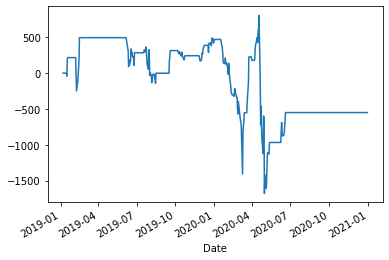

In [13]:
algorithm_book['PnL_cumsum'].plot()

# 4. Optimizer 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

<AxesSubplot:xlabel='Date'>

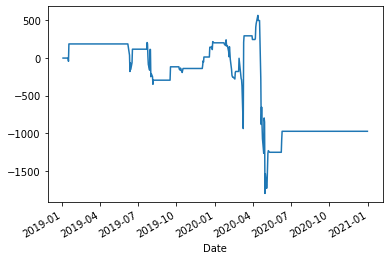

In [68]:
def generate_backtest(j, g, s, M):
    X_raw = quandl.get('EOD/RYE', returns = 'pandas', 
            api_key = my_api_key, start_date = '2018-12-02', end_date = '2020-12-31')
    Y_raw = quandl.get('EOD/XOP', returns = 'pandas', 
            api_key = my_api_key, start_date = '2018-12-02', end_date = '2020-12-31')
    
    of_interest = ['Adj_Close', 'Adj_Volume']

    X_raw = X_raw[of_interest]
    Y_raw = Y_raw[of_interest]
    
    estimate_daily_dollar_volume(X_raw)
    estimate_daily_dollar_volume(Y_raw)
    
    get_rolling_median(15, X_raw)
    get_rolling_median(15, Y_raw)
    
    
    X = X_raw
    Y = Y_raw

    #get the M-day return on X and Y 
    X['returns'] = X['Adj_Close'].pct_change(M)
    Y['returns'] = Y['Adj_Close'].pct_change(M)

    get_N_t(X_raw, Y_raw)


    #I cleaned a bit of the data in the CSV, getting rid of the extra text etc 
    F_and_F = pd.read_csv('/Users/zachmariani/FINM/F&F.CSV')

    #cut out a lot to make it faster
    F_and_F = F_and_F.iloc[22000:]

    #fix the indexing of the data
    F_and_F['Date'] = F_and_F['Date'].apply(str)
    F_and_F['Date'] = F_and_F['Date'].str[0:4] + '-' + F_and_F['Date'].str[4:6] + '-' + F_and_F['Date'].str[6:8]
    F_and_F['Date'] = pd.to_datetime(F_and_F['Date'])

    F_and_F = F_and_F.set_index('Date')
    
    F_and_F = F_and_F.loc['2018-12-02':'2020-12-31']
    
    F_and_F_first_days_of_month = F_and_F.iloc[F_and_F.reset_index().groupby(F_and_F.index.to_period('M'))['Date'].idxmin()]
    F_and_F_first_days_of_month['First_Day_of_the_Month'] = 1

    #disqualify this first one as per assignment
    F_and_F_first_days_of_month.at['2018-12-03', 'First_Day_of_the_Month'] = None
    
    
    #here we do a similar thing to get the last days of the month 
    F_and_F_last_days_of_month = F_and_F.iloc[F_and_F.reset_index().groupby(F_and_F.index.to_period('M'))['Date'].idxmax()]
    F_and_F_last_days_of_month['Last_Day_of_the_Month'] = 1

    #we get rid of this one 
    F_and_F_last_days_of_month.at['2018-12-31', 'Last_Day_of_the_Month'] = None


    X['N_t_over_100'] = X['N_t'] / 100
    Y['N_t_over_100'] = Y['N_t'] / 100

    #this gets the number of shares we could possibly trade on each day 
    X['num_of_shares_to_possibly_trade'] = np.floor(X['N_t_over_100'] / X['Adj_Close'])
    Y['num_of_shares_to_possibly_trade'] = np.floor(Y['N_t_over_100'] / Y['Adj_Close'])


    #we then transition from just the data to what I call the algorithm book 
    algorithm_book = pd.DataFrame()
    algorithm_book['Spread'] = np.abs(X['returns'] - Y['returns'])
    algorithm_book['X_recent_return'] = X['returns']
    algorithm_book['Y_recent_return'] = Y['returns']

    #copy over a couple of things that will be useful to have 
    algorithm_book['X_shares_to_possibly_trade'] = X['num_of_shares_to_possibly_trade']
    algorithm_book['Y_shares_to_possibly_trade'] = Y['num_of_shares_to_possibly_trade']

    algorithm_book['X_adj_close'] = X['Adj_Close']
    algorithm_book['Y_adj_close'] = Y['Adj_Close']

    #as mentioned earlierthis logic assumes that the F and F data has the exact same timeseries as the Quandl data
    #might be worth a minute to just double check 
    algorithm_book['First_Day_of_the_Month'] = F_and_F_first_days_of_month['First_Day_of_the_Month']
    algorithm_book['Last_Day_of_the_Month'] = F_and_F_last_days_of_month['Last_Day_of_the_Month']
    algorithm_book['Must_Close'] = algorithm_book['Last_Day_of_the_Month']
    algorithm_book['Eligible_to_Open'] = \
    algorithm_book['First_Day_of_the_Month'].fillna(method = 'ffill') - algorithm_book['Must_Close'].fillna(0)



    algorithm_book.loc[(algorithm_book['Spread'] > g) & \
                       (algorithm_book['Eligible_to_Open'] == 1), 'spread_above_g_and_eligible_to_open'] = 1

    algorithm_book['spread_above_g_shift'] = algorithm_book['spread_above_g_and_eligible_to_open'].shift(1).fillna(0)
    algorithm_book.loc[(algorithm_book['spread_above_g_and_eligible_to_open'] - \
                        algorithm_book['spread_above_g_shift'] == 1), 'opened_today'] = 1.0

    algorithm_book.loc[(algorithm_book['Spread']) < j, 'spread_below_j'] = 0

    #to clean it up
    algorithm_book.drop('spread_above_g_shift', axis = 1, inplace=True)

    algorithm_book.loc[(algorithm_book['X_recent_return'] > algorithm_book['Y_recent_return']), 'sec_to_short'] = 'X'
    algorithm_book.loc[(algorithm_book['X_recent_return'] < algorithm_book['Y_recent_return']), 'sec_to_short'] = 'Y'

    algorithm_book['currently_open'] = algorithm_book['opened_today'].add(algorithm_book['spread_below_j'], fill_value =0).fillna(method = 'ffill')



    X_map = {
        'X' : -1, 
        'Y' : 1
    }
    x_multiplier = algorithm_book['sec_to_short'].replace(X_map)

    Y_map = {
        'Y' : -1, 
        'X' : 1
    }
    y_multiplier = algorithm_book['sec_to_short'].replace(Y_map)




    algorithm_book.loc[(algorithm_book['opened_today'] == 1) , 'x_shares_traded_today'] = \
        algorithm_book['X_shares_to_possibly_trade'] * x_multiplier

    algorithm_book.loc[(algorithm_book['opened_today'] == 1) , 'y_shares_traded_today'] = \
        algorithm_book['Y_shares_to_possibly_trade'] * y_multiplier

    running_x = algorithm_book['x_shares_traded_today'].copy().fillna(method = 'ffill')
    running_y = algorithm_book['y_shares_traded_today'].copy().fillna(method = 'ffill')



    #if they closed 
    closed_today = algorithm_book['currently_open'] - algorithm_book['currently_open'].fillna(0).shift(1)

    algorithm_book.loc[(closed_today == -1) , 'x_shares_traded_today'] = \
         -1 * running_x

    algorithm_book.loc[(closed_today == -1) , 'y_shares_traded_today'] = \
         -1 * running_y

    algorithm_book['x_on_books'] = algorithm_book['x_shares_traded_today'].fillna(method = 'ffill')
    algorithm_book.loc[(algorithm_book['currently_open'] == 0), 'x_on_books'] = 0
    algorithm_book['y_on_books'] = algorithm_book['y_shares_traded_today'].fillna(method = 'ffill')
    algorithm_book.loc[(algorithm_book['currently_open'] == 0), 'y_on_books'] = 0

    algorithm_book.loc[(algorithm_book['x_on_books'] != 0), 'PnL_needed_on_this_day'] = 1
    algorithm_book['PnL_needed_on_this_day'] = algorithm_book['PnL_needed_on_this_day'].shift(1)

    num_of_contracts_held = algorithm_book['x_on_books'].shift(1)
    price_change_per_contract = algorithm_book['X_adj_close'].diff()
    algorithm_book['x_pnl'] = price_change_per_contract * num_of_contracts_held

    num_of_contracts_held = algorithm_book['y_on_books'].shift(1)
    price_change_per_contract = algorithm_book['Y_adj_close'].diff()
    algorithm_book['y_pnl'] = price_change_per_contract * num_of_contracts_held

    algorithm_book['PnL_total'] = algorithm_book['x_pnl'] + algorithm_book['y_pnl']

    algorithm_book['PnL_cumsum'] = algorithm_book['PnL_total'].cumsum()
    
    return algorithm_book


output = generate_backtest(j = 0.04, g = 0.06, s = 1, M = 15)


output['PnL_cumsum'].plot()






    
